In [1]:
%tensorflow_version 1.x
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
import numpy as np
import tensorflow as tf 
from tensorflow.keras.models import Model
from tensorflow import keras
import cv2
#plot_model(model)
#import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras import utils as np_utils
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import preprocess_input
print(tf.__version__)

TensorFlow 1.x selected.


Using TensorFlow backend.


1.15.2


https://www.kaggle.com/anandad/classify-fashion-mnist-with-vgg16

In [2]:
num_classes = 10
input_shape = (28, 28, 1)

In [3]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape)
print(type(x_train))
dim = (48,48)
#convert 28x28 grayscale to 48x48 rgb channels
def to_rgb(img):
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 
    img_rgb = np.asarray(np.dstack((img, img, img)), dtype=np.uint8)
    return img_rgb
rgb_list = []
#convert X_train data to 48x48 rgb values
for i in range(len(x_train)):
    rgb = to_rgb(x_train[i])
    rgb_list.append(rgb)
    #print(rgb.shape)

#x_train = to_rgb(x_train)

rgb_arr = np.stack([rgb_list],axis=4)
train_X = np.squeeze(rgb_arr, axis=4)
print(train_X.shape)
rgb_list = []
#convert X_train data to 48x48 rgb values
for i in range(len(x_test)):
    rgb = to_rgb(x_test[i])
    rgb_list.append(rgb)
    #print(rgb.shape)

#x_test = to_rgb(x_test)
rgb_arr = np.stack([rgb_list],axis=4)
test_X = np.squeeze(rgb_arr, axis=4)
print(test_X.shape)
# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)



#print("x_train shape:", x_train.shape)
# # Scale images to the [0, 1] range
# x_train = x_train.astype("float32") / 255
# x_test = x_test.astype("float32") / 255
# # Make sure images have shape (28, 28, 1)
# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)
# print("x_train shape:", x_train.shape)
# print("x_test shape:",x_test.shape)
# print(x_train.shape[0], "train samples")
# print(x_test.shape[0], "test samples")
# x_train = np.dstack([x_train]*3)
# x_test = np.dstack([x_test]*3)
# print("x_train shape:", x_train.shape)
# print("x_test shape:",x_test.shape)
# # convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
<class 'numpy.ndarray'>
(60000, 48, 48, 3)
(10000, 48, 48, 3)


In [4]:
# Normalise the data and change data type
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [5]:
# Converting Labels to one hot encoded format
train_Y_one_hot = to_categorical(y_train)
test_Y_one_hot = to_categorical(y_test)

In [6]:
# Splitting train data as train and validation data
train_X,valid_X,train_label,valid_label = train_test_split(train_X,
                                                           train_Y_one_hot,
                                                           test_size=0.2,
                                                           random_state=13
                                                           )

In [7]:
# Finally check the data size whether it is as per tensorflow and VGG16 requirement
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

In [8]:
# Define the parameters for instanitaing VGG16 model. 
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

In [9]:
# Preprocessing the input 
train_X = preprocess_input(train_X)
valid_X = preprocess_input(valid_X)
test_X  = preprocess_input (test_X)

In [10]:
## Loading VGG16 model
base_model = VGG16(weights=None, include_top=False, input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [11]:
# Extracting features
train_features = base_model.predict(np.array(train_X), batch_size=BATCH_SIZE, verbose=1)
test_features = base_model.predict(np.array(test_X), batch_size=BATCH_SIZE, verbose=1)
val_features = base_model.predict(np.array(valid_X), batch_size=BATCH_SIZE, verbose=1)
#for layer in conv_base.layers:
#    layer.trainable = False


12000/12000 [==============================] - 13s 1ms/step


In [12]:
# 6.1 Saving the features so that they can be used for future
np.savez("train_features", train_features, train_label)
np.savez("test_features", test_features, y_test)
np.savez("val_features", val_features, valid_label)

In [13]:
# Current shape of features
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

(48000, 1, 1, 512) 
 (10000, 1, 1, 512) 
 (12000, 1, 1, 512)


In [14]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (48000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))
val_features_flat = np.reshape(val_features, (12000, 1*1*512))

In [15]:
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers.advanced_activations import LeakyReLU

In [16]:
# 7.0 Define the densely connected classifier followed by leakyrelu layer and finally dense layer for the number of classes
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 100

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(num_classes, activation='softmax'))

In [17]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [18]:
# Compile the model.
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
  # optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc',f1_m,precision_m, recall_m])

In [19]:
# Incorporating reduced learning and early stopping for callback
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

/tensorflow-1.15.2/python3.7/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [20]:
# Train the the model
history = model.fit(
    train_features_flat,
    train_label,
    epochs=NB_EPOCHS,
    validation_data=(val_features_flat, valid_label),
    callbacks=callbacks
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 7s 146us/step - loss: 2.3031 - acc: 0.1108 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.3022 - val_acc: 0.1106 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
48000/48000 [==============================] - 7s 140us/step - loss: 2.3013 - acc: 0.1128 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.3019 - val_acc: 0.1106 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/100
48000/48000 [==============================] - 7s 138us/step - loss: 2.3012 - acc: 0.1128 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.3019 - val_acc: 0.1106 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/100
48000/48000 [==============================] - 7s 139us/step - loss: 2.3012 -

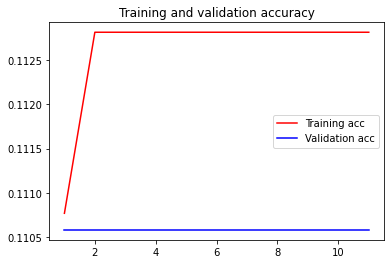

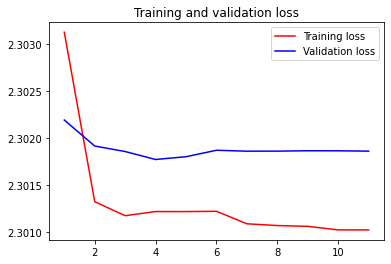

In [21]:
# plot the loss and accuracy
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
data_dir ='drive/MyDrive/Thesis/Baseline/Weights/MNIST'

In [25]:
import os
import random
import shutil
if os.path.isdir(data_dir) == False:
    os.makedirs(data_dir)

In [26]:
model.save_weights("drive/MyDrive/Thesis/Baseline/Weights/MNIST/VGG16_Weights.h5")